# Общая информация
Целью является создание модели прогнозирования энергопотребления просьюмеров для снижения затрат на небаланс энергии.

Проект направлен на решение проблемы энергетического дисбаланса - ситуации, когда ожидаемое потребление энергии не совпадает с ее фактическим использованием или производством. Значительная часть энергетического дисбаланса приходится на потребителей, которые как потребляют, так и производят энергию. Несмотря на то, что они составляют лишь небольшую часть всех потребителей, их непредсказуемое потребление энергии создает логистические и финансовые проблемы для энергетических компаний.
 
*Enefit* – одна из крупнейших энергетических компаний Балтийского региона. Как эксперты в области энергетики, мы помогаем клиентам индивидуально и гибко планировать свой экологический путь, а также реализовывать его, используя экологически чистые энергетические решения.

В настоящее время Enefit пытается решить проблему дисбаланса, разрабатывая внутренние модели прогнозирования и опираясь на прогнозы третьих сторон. Однако эти методы оказались недостаточными из-за низкой точности прогнозирования энергетического поведения просьюмеров. Недостатки этих нынешних методов заключаются в их неспособности точно учесть широкий спектр переменных, влияющих на поведение потребителей, что приводит к высоким издержкам дисбаланса.

### Оценивание
Основной метрикой заказчика является MAE (средняя абсолютная ошибка):

$MAE = \dfrac{1}{n} \sum_{i=1}^n |y_i - x_i|$

Где:

- $n$ — общее количество объектов
- $y_i$ — прогнозируемое значение таргета
- $x_i$ — наблюдаемое значение таргета

### Глоссарий
**Просьюмер** — 
1. человек, который покупает электронные товары, являющиеся стандартом между товарами, предназначенными для потребителей, и профессионалами
2. потребитель, который участвует в разработке или настройке продуктов для своих собственных нужд

В текущем проекте считаем просьюмером любого потребителя электроэнергии.

**EICs** — European Identifier Code.

# Оглавление
1. [Предобработка данных](#preprocessing)
    1. [Знакомство с данными](#data-familiarization)
    2. [Удаление пропусков](#problem-solving)



In [1]:
##  Знакомство с данными <a class="anchor" id="data-familiarization"></a>

# Предобработка данных <a class="anchor" id="preprocessing"></a>

##  Знакомство с данными <a class="anchor" id="data-familiarization"></a>

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import warnings


# запишем путь директории
basedir = os.path.abspath(os.getcwd())
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

In [3]:
# загрузим данные
try:
    clients = pd.read_csv(os.path.join(basedir, 'data/client.csv'))
    train = pd.read_csv(os.path.join(basedir, 'data/train.csv'))
    gas_prices = pd.read_csv(os.path.join(basedir, 'data/gas_prices.csv'))
    electricity_prices = pd.read_csv(os.path.join(basedir, 'data/electricity_prices.csv'))
    # forecast_weather = pd.read_csv(os.path.join(basedir, 'data/forecast_weather.csv'))
    # historical_weather = pd.read_csv(os.path.join(basedir, 'data/historical_weather.csv'))
    # county_map = pd.read_json(os.path.join(basedir, 'data/county_id_to_name_map.json'), typ='series')
except:
    raise Exception('Check the files')

In [4]:
def get_dataset_info(df: pd.DataFrame) -> None:
    """
    Функция выводит общую инфу
    о датасете одним полем
    
    :param pd.DataFrame df: pandas-датафрейм, который нужно проанализировать
    """
    display(df.head())
    print('\n')
    print(df.info())
    print('\n')
    display(df.describe())
    print('\n')
    print(df.isna().sum())
    print('\n')
    print(f'Дубликаты: {df.duplicated().sum()}')
    print('it`s over')

In [5]:
get_dataset_info(clients)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB
None




,product_type,county,eic_count,installed_capacity,is_business,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,322.898876
std,1.081713,4.780750,144.064389,2422.233120,0.498652,182.075724
min,0.000000,0.000000,5.000000,5.500000,0.000000,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,637.000000




product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64


Дубликаты: 0
it`s over


Видим, что в этом датасете у нас 41919 объектов с обезличенной информацией о клиентах. Пропусков и полных дубликатов нет. Присутствуют следующие поля:
- **product_type** — тип продукта
- **county** — ID округа
- **eic_count** — количество точек потребления
- **installed_capacity** — установленная мощность фотоэлектрической солнечной панели в киловаттах
- **is_business** — является ли просьюмер бизнесом
- **date** — дата (вероятно, создания записи)
- **data_block_id** — все строки с одним и тем же data_block_id будут доступны в одно и то же время прогноза. Это зависит от того, какая информация доступна во время фактических прогнозов, каждое утро в 11 часов утра. Например, если прогноз погоды data_block_id для предсказаний, сделанных 31 октября, равен 100, то исторический data_block_id погоды на 31 октября будет равен 101, поскольку исторические данные о погоде фактически доступны только на следующий день.

In [6]:
get_dataset_info(train)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None




,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01




county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64


Дубликаты: 0
it`s over


В трейне у нас чуть более 2 миллионов объектов, у которых 528 пропусков в таргете. Учитывая, что их очень мало, эти строки просто удалим позже.
Поля:
- **county** — идентификационный код округа.
- **is_business** — логическое значение, определяющее, является ли просьюмер бизнесом.
- **product_type** — идентификационный код со следующим сопоставлением кодов типам контрактов: 
    - 0: «Комбинированный»
    - 1: «Фиксированный»
    - 2: «Общий сервис»
    - 3: «Спотовый»
- **target** — объем потребления или производства для соответствующего сегмента за час. Сегменты определяются округом, is_business и Product_type.
- **is_consumption** — логическое значение, указывающее, является ли целью этой строки потребление или производство.
- **datetime** — эстонское время в формате EET (UTC+2) / EEST (UTC+3).
- **data_block_id** — все строки с одним и тем же data_block_id будут доступны в одно и то же время прогноза. Это зависит от того, какая информация доступна во время фактических прогнозов, каждое утро в 11 часов утра. Например, если прогноз погоды data_block_id для предсказаний, сделанных 31 октября, равен 100, то исторический data_block_id погоды на 31 октября будет равен 101, поскольку исторические данные о погоде фактически доступны только на следующий день.
- **row_id** — уникальный идентификатор строки.
- **prediction_unit_id** — уникальный идентификатор для комбинации округа, is_business и Product_type. Новые единицы прогнозирования могут появляться или исчезать в тестовом наборе.

In [7]:
get_dataset_info(gas_prices)

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB
None




,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
count,637.000000,637.000000,637.000000
mean,95.036750,107.754631,319.000000
std,47.552295,54.743666,184.030342
min,28.100000,34.000000,1.000000
25%,60.000000,67.530000,160.000000
50%,85.210000,93.470000,319.000000
75%,109.000000,130.740000,478.000000
max,250.000000,305.000000,637.000000




forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64


Дубликаты: 0
it`s over


Здесь у нас информация по прогнозу цен на топливо.
- **origin_date** — дата, когда стали доступны цены на сутки вперед.
- **forecast_date**  — дата, когда прогнозные цены должны быть актуальными.
- **(lowest/highest)_price_per_mwh** — самая низкая/самая высокая цена природного газа, которая будет продаваться на день вперед в этот торговый день, в евро за эквивалент мегаватт-часа.
- **data_block_id**

In [8]:
get_dataset_info(electricity_prices)

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB
None




,euros_per_mwh,data_block_id
count,15286.000000,15286.000000
mean,157.064176,318.990710
std,121.148625,183.890301
min,-10.060000,1.000000
25%,85.290000,160.000000
50%,128.280000,319.000000
75%,199.797500,478.000000
max,4000.000000,637.000000




forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64


Дубликаты: 0
it`s over


Данные по ценам на электричество (почти аналогично газу):

- **origin_date**
- **forecast_date**
- **euros_per_mwh** — цена на электроэнергию на завтрашний день торгуется в евро за мегаватт-час.
- **data_block_id**

In [9]:
# get_dataset_info(forecast_weather)

Прогнозы погоды, которые были бы доступны на момент прогнозирования от Европейского центра среднесрочных прогнозов погоды. 3,5 миллионов записей.

- **latitude, longitude** — координаты прогноза погоды.
- **origin_datetime** — временная метка создания прогноза.
- **hours_ahead** — количество часов между созданием прогноза и прогнозом погоды. Каждый прогноз охватывает в общей сложности 48 часов.
- **temperature** — температура воздуха на высоте 2 метра над землей в градусах Цельсия.
- **dewpoint** — температура точки росы на высоте 2 метра над землей в градусах Цельсия.
- **cloudcover_(low/mid/high/total)** — процент неба, покрытого облаками в следующих диапазонах высот: 0–2 км, 2–6, 6+ и общий.
- **10_metre_(u/v)_wind_component** — составляющая скорости ветра (восточное/северное направление), измеренная на высоте 10 метров над поверхностью земли в метрах в секунду.
- **data_block_id**
- **forecast_datetime** — временная метка прогнозируемой погоды. Генерируется из origin_datetime плюс hours_ahead.
- **direct_solar_radiation** — прямая солнечная радиация, достигающая поверхности в плоскости, перпендикулярной направлению Солнца, накопленная за предыдущий час, в ватт-часах на квадратный метр.
- **surface_solar_radiation_downwards** — солнечное излучение, как прямое, так и рассеянное, достигающее горизонтальной плоскости на поверхности Земли, в ватт-часах на квадратный метр.
- **snowfall** — снегопад за предыдущий час в метрах водного эквивалента.
- **total_precipitation** — накопленная жидкость, состоящая из дождя и снега, выпавшая на поверхность Земли за предыдущий час, в метрах.

In [10]:
# get_dataset_info(historical_weather)

Исторические данные погоды. 

- **datetime**
- **temperature**
- **dewpoint**
- **rain** — разница от условных обозначений прогноза. Дождь от крупномасштабных погодных систем за предыдущий час в миллиметрах.
- **snowfall** — разница от условного прогноза. Снегопад за предыдущий час в сантиметрах.
- **surface_pressure** — давление воздуха на поверхности в гектопаскалях.
- **cloudcover_(low/mid/high/total)** — разница от прогноза. Облачность на высоте 0–3 км, 3–8, 8+ и общая.
- **windspeed_10m** — разница от прогноза. Скорость ветра на высоте 10 метров над землей в метрах в секунду.
- **winddirection_10m** — разница от прогноза. Направление ветра на высоте 10 метров над землей в градусах.
- **shortwave_radiation** — разница от прогноза. Глобальное горизонтальное излучение в ватт-часах на квадратный метр.
- **direct_solar_radiation**
- **diffuse_radiation** — разница от прогноза. Диффузное солнечное излучение в ватт-часах на квадратный метр.
- **(latitude/longitude)** — координаты метеостанции.
- **data_block_id**

In [11]:
# county_map

Эта информация связывает id с названиями округов Эстонии.

## Удаление пропусков <a class="anchor" id="problem-solving"></a>

Сначала удалим пропуски в таблице train. Их там примерно полтысячи.

In [12]:
train = train.dropna(subset='target')
train.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [13]:
# то же самое для предсказанной погоды
# forecast_weather = forecast_weather.dropna(subset='surface_solar_radiation_downwards')
# forecast_weather.isna().sum()

## Изменение типов данных

Изменим даты в датасетах на тип `datetime`.

In [14]:
def change_datetime_type(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Функция меняет тип указанных полей на datetime
    :param pd.DataFrame df: Pandas-датафрейм, в котором нужно изменить поля
    :param List[str] columns: список столбцов с датами
    """
    if not columns:
        return Exception('Список столбцов не может быть пустым / Указание столбцов таблицы обязательно')
    for col in columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = df[col].dt.strftime('%Y-%m-%d %H:%M:%S')
        df[col] = pd.to_datetime(df[col])
    return df

In [15]:
clients = change_datetime_type(clients, ['date'])
train = change_datetime_type(train, ['datetime'])
gas_prices = change_datetime_type(gas_prices, ['forecast_date', 'origin_date'])
electricity_prices = change_datetime_type(electricity_prices, ['forecast_date', 'origin_date'])
# forecast_weather = change_datetime_type(forecast_weather, ['origin_datetime', 'forecast_datetime'])
# historical_weather = change_datetime_type(historical_weather, ['datetime'])

In [16]:
# переименуем столбцы для единообразия
clients = clients.rename(columns={'date': 'datetime'})
gas_prices = gas_prices.rename(columns={'forecast_date': 'forecast_datetime', 'origin_date': 'origin_datetime'})
electricity_prices = electricity_prices.rename(columns={'forecast_date': 'forecast_datetime', 'origin_date': 'origin_datetime'})

## EDA

Теперь проведем разведывательный анализ данных для более глубокого погружения в данные. Сначала проверим совпадение временных промежутков в датасетах, так как работать нам придется с временными рядами.

In [17]:
# оценим, какие временные промежутки в данных заказчика
def show_min_max_date(data: pd.Series) -> None:
    """
    Функция печатает минимальную и максимальную даты для нужного поля
    :param pd.Series data: Series-объект Pandas с датами
    """
    print(f'Минимальная дата: {data.min()}')
    print(f'Максимальная дата: {data.max()}')

In [18]:
show_min_max_date(clients['datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-29 00:00:00


In [19]:
show_min_max_date(train['datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-31 23:00:00


In [20]:
show_min_max_date(gas_prices['forecast_datetime'])
show_min_max_date(gas_prices['origin_datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 00:00:00
Минимальная дата: 2021-08-31 00:00:00
Максимальная дата: 2023-05-29 00:00:00


In [21]:
show_min_max_date(electricity_prices['forecast_datetime'])
show_min_max_date(electricity_prices['origin_datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 23:00:00
Минимальная дата: 2021-08-31 00:00:00
Максимальная дата: 2023-05-29 23:00:00


In [22]:
# show_min_max_date(forecast_weather['origin_datetime'])
# show_min_max_date(forecast_weather['forecast_datetime'])

In [23]:
# show_min_max_date(historical_weather['datetime'])

Видим, что периоды даны одинаковые, так что с этим проблем возникнуть не должно. Соединим таблицы для дальнейшего анализа.

In [24]:
# это всё закомментриуем, чтобы при перезапуске ячеек заново не делать

# merge_data = train.merge(gas_prices[['lowest_price_per_mwh', 'highest_price_per_mwh', 'data_block_id']], how='left', on=['data_block_id'])
# merge_data = merge_data.merge(electricity_prices[['euros_per_mwh', 'forecast_datetime']], how='left', left_on=['datetime'], right_on=['forecast_datetime'])
# merge_data.to_pickle(os.path.join(basedir, 'data/data.pkl'))

In [25]:
# загрузим объединенные данные
final_data = pd.read_pickle(os.path.join(basedir, 'data/data.pkl'))

Посмотрим теперь на таблицу, что будет для нас основной в дальнейшей работе.

In [26]:
get_dataset_info(final_data)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,forecast_datetime
0,0,0,1,0.713,0,2021-09-01,0,0,0,NaN,NaN,92.51,2021-09-01
1,0,0,1,96.590,1,2021-09-01,0,1,0,NaN,NaN,92.51,2021-09-01
2,0,0,2,0.000,0,2021-09-01,0,2,1,NaN,NaN,92.51,2021-09-01
3,0,0,2,17.314,1,2021-09-01,0,3,1,NaN,NaN,92.51,2021-09-01
4,0,0,3,2.904,0,2021-09-01,0,4,2,NaN,NaN,92.51,2021-09-01




<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   county                 int64         
 1   is_business            int64         
 2   product_type           int64         
 3   target                 float64       
 4   is_consumption         int64         
 5   datetime               datetime64[ns]
 6   data_block_id          int64         
 7   row_id                 int64         
 8   prediction_unit_id     int64         
 9   lowest_price_per_mwh   float64       
 10  highest_price_per_mwh  float64       
 11  euros_per_mwh          float64       
 12  forecast_datetime      datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(7)
memory usage: 215.5 MB
None




,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh
count,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2017824.0,2.017824e+06,2.017824e+06,2.017824e+06,2.014896e+06,2.014896e+06,2.014438e+06
mean,7.297039e+00,5.368268e-01,1.898927e+00,2.748556e+02,0.5,3.218754e+02,1.009178e+06,3.304540e+01,9.546883e+01,1.083110e+02,1.574594e+02
std,4.780994e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826310e+02,5.826378e+05,1.959062e+01,4.758257e+01,5.476264e+01,1.213383e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.810000e+01,3.400000e+01,-1.006000e+01
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045818e+05,1.600000e+01,6.000000e+01,6.767000e+01,8.529000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009172e+06,3.300000e+01,8.590000e+01,9.400000e+01,1.287400e+02
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01,1.097400e+02,1.330000e+02,1.999700e+02
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01,2.500000e+02,3.050000e+02,4.000000e+03




county                      0
is_business                 0
product_type                0
target                      0
is_consumption              0
datetime                    0
data_block_id               0
row_id                      0
prediction_unit_id          0
lowest_price_per_mwh     2928
highest_price_per_mwh    2928
euros_per_mwh            3386
forecast_datetime        3386
dtype: int64


Дубликаты: 0
it`s over


У нас появилось около 3000 пропусков после присоединения. Учитывая, что объектов в датасете больше 2 миллионов, от этих пропусков можно просто избавиться.

In [27]:
# удалим пропуски и выведем общее их количество
final_data = final_data.dropna(subset=['lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh', 'forecast_datetime'])
final_data.isna().sum().sum()

0

In [28]:
# удалим столбцы, которые не понадобятся при обучении моделей
final_data = final_data.drop(['data_block_id', 'row_id', 'prediction_unit_id', 'forecast_datetime'], axis=1)

,is_business
1,1079862
0,931648


<AxesSubplot: >

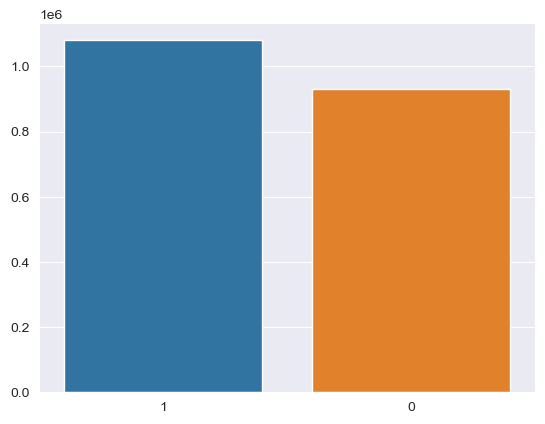

In [29]:
# взглянем на распределение просьюмеров b2b И b2c
is_business = pd.DataFrame(final_data['is_business'].value_counts())
display(is_business)
display(sns.barplot(data=is_business.T))

Как видим, бизнеса чуть больше, чем обычных потребителей.

In [30]:
# посмотрим то же на тип продукта
final_data['product_type'].value_counts()

3    915480
1    779020
0    169996
2    147014
Name: product_type, dtype: int64

Как видим большинство контрактов спотовые, вторые по используемости фиксированные тарифы, а дальше комбинированный и общий сервис. Посмотрим в разрезе типов клиентов.

In [31]:
final_data.pivot_table(index='product_type', columns='is_business', values='target', aggfunc='count')

is_business,0,1
product_type,,
0,NaN,169996.0
1,425832.0,353188.0
2,78592.0,68422.0
3,427224.0,488256.0


Можно обратить внимание, что комбинированным типов бользуется только бизнес, а для остальных более менее поровну. Давайте также взглянем, как много тех, потребляет электроэнергию для производства и по другим нуждам.

In [32]:
final_data['is_consumption'].value_counts()

0    1005755
1    1005755
Name: is_consumption, dtype: int64

Удивительно, но разницы нет нет вовсе, обеих групп ровно поровну.

Изучим временные ряды по разным годам, а потребление просуммируем. Потом ресемплируем по дням или неделям, после чего посчитаем среднее с графиком.

In [33]:
date_and_target = pd.DataFrame(final_data[['datetime', 'target']].groupby('datetime')['target'].sum())
date_and_target.head()

,target
datetime,
2021-09-02 00:00:00,18944.316
2021-09-02 01:00:00,18293.199
2021-09-02 02:00:00,18336.394
2021-09-02 03:00:00,18030.154
2021-09-02 04:00:00,18242.519


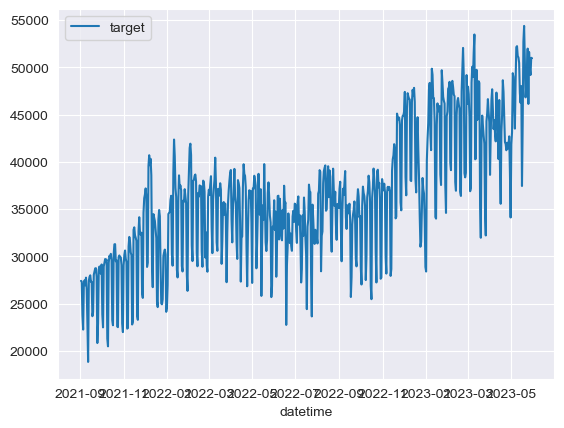

In [34]:
# сдедаем копию датафрейма
date_and_target_re = date_and_target.copy()

# изменим тип индекса
date_and_target_re.index = pd.to_datetime(date_and_target_re.index)

# ресеплируем по дням и выведем графиком
sns.lineplot(date_and_target_re.resample('1D').mean());

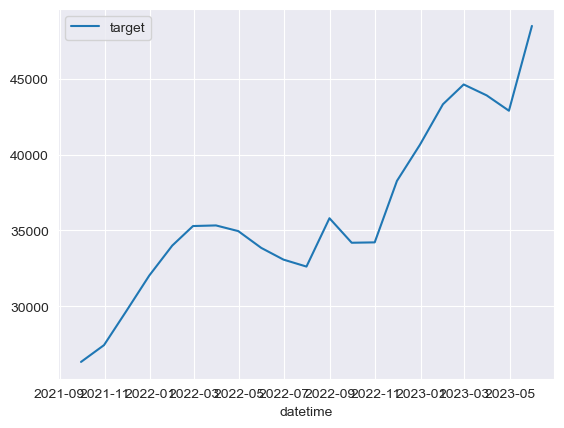

In [35]:
# сдедаем то же для месяцев
sns.lineplot(date_and_target_re.resample('1M').mean());

Видим тренд постоянного увеличения потребления электроэнергии. Взглянем в разрезе одного года.

<AxesSubplot: xlabel='datetime'>

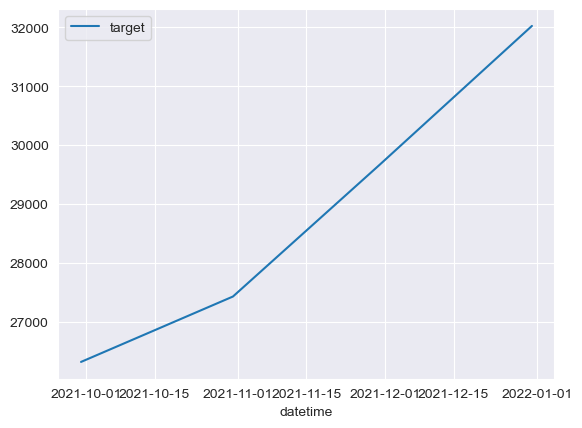

In [36]:
# для месяцев 2021 года
display(sns.lineplot(date_and_target_re.query('index < "2022-01-01"').resample('1M').mean()))

<AxesSubplot: xlabel='datetime'>

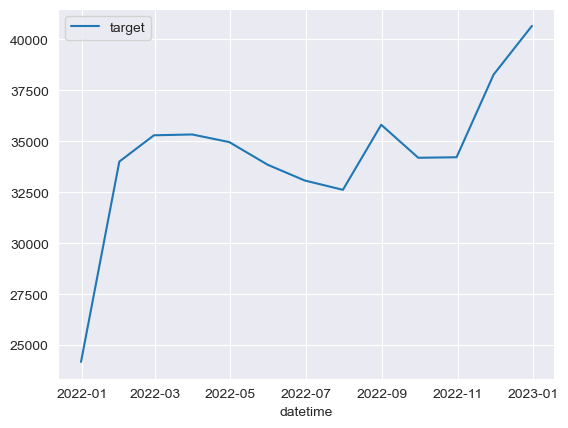

In [37]:
# для месяцев 2022 года
display(sns.lineplot(date_and_target_re.query('index > "2021-12-31" and index < "2023-01-01"').resample('1M').mean()));

<AxesSubplot: xlabel='datetime'>

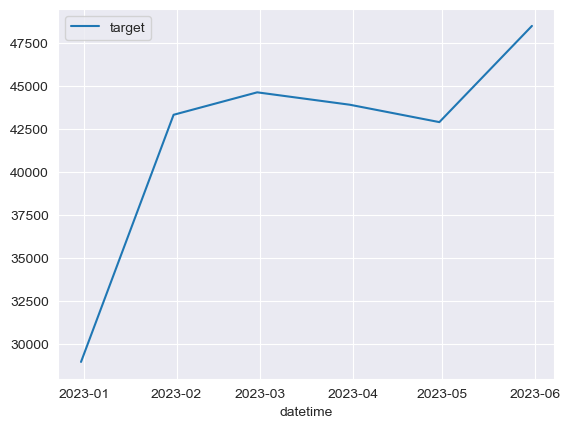

In [38]:
# для месяцев 2023 года
display(sns.lineplot(date_and_target_re.query('index > "2022-12-31"').resample('1M').mean()));

Графики получаются похожими, но стоит учитывать, что 2021 и 2023 год взяты не полностью. Попробуем оценить сезонность и тренды при помощи статистической модели.

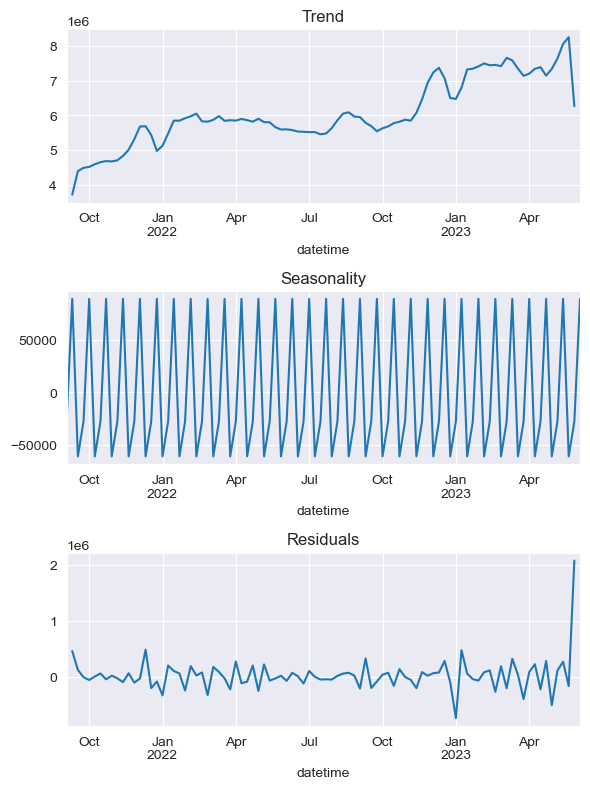

In [39]:
date_and_target_re_1w = date_and_target_re.resample('1W').sum()
date_and_target_re_1w.sort_index(inplace=True)
decomposed = seasonal_decompose(date_and_target_re_1w, period=3)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Четко наблюдаемого тренда нет, а сезонность выглядит как стационарный процесс с четкой повторяемостью. Оценим также при помощи скользязещего среднего и стандартного отклонения.

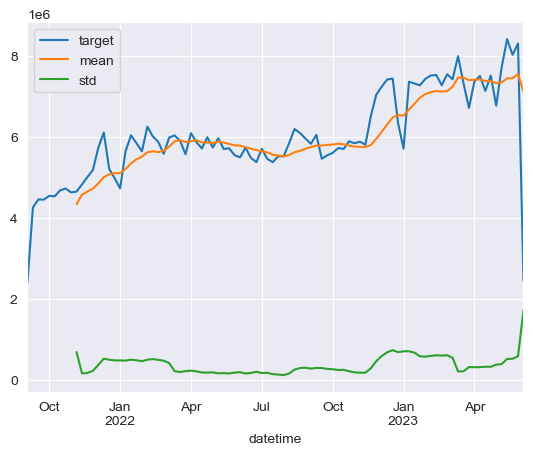

In [40]:
date_and_target_re_1w['mean'] = date_and_target_re_1w['target'].rolling(10).mean()
date_and_target_re_1w['std'] = date_and_target_re_1w['target'].rolling(10).std()
date_and_target_re_1w.plot();

Сам временной ряд, который будем прогнозировать, кажется нестационарным, хоть и имеет тренд на повышение потребления, но также резкое падание в конце наблюдений. Это может оказать влияние на модель.

## Дополнительные фичи

Дополним датасет дополнительными данными, исходя из даты и времени, а сам тип datetime сделаем индексом датасета.

In [41]:
def make_datetime_features(df: pd.DataFrame, lag: int, rolling_size: int) -> pd.DataFrame:
    """
    Функция создает дополнительные признаки даты и времени,
    а также добавляет лаги и скользящее среднее
    
    :param pd.DataFrame df: датафрейм, который нужно дополнить
    :param int lag: число, на которое нужно сделать сдвиг по данным
    :param int rolling_size: размер скользящего окна
    """
    df['month'] = df['datetime'].dt.month
    df['week'] = df['datetime'].dt.week
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    for lag in range(1, lag + 1):
        df['lag_{}'.format(lag)] = df['target'].shift(lag)
    
    df['rolling_mean'] = df['target'].shift().rolling(rolling_size).mean()
    
    return df

In [42]:
final_data = make_datetime_features(final_data, 5, 5)

In [43]:
# сделаем datetime индексом
final_data = final_data.set_index('datetime')

# удалим пропуски
final_data = final_data.dropna()

In [44]:
final_data.head()

,county,is_business,product_type,target,is_consumption,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,month,week,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2021-09-02,0,0,3,735.696,1,45.23,46.32,96.99,9,35,3,2,0,1.003,21.008,0.000,109.366,1.687,26.6128
2021-09-02,0,1,0,0.000,0,45.23,46.32,96.99,9,35,3,2,0,735.696,1.003,21.008,0.000,109.366,173.4146
2021-09-02,0,1,0,75.800,1,45.23,46.32,96.99,9,35,3,2,0,0.000,735.696,1.003,21.008,0.000,151.5414
2021-09-02,0,1,1,0.000,0,45.23,46.32,96.99,9,35,3,2,0,75.800,0.000,735.696,1.003,21.008,166.7014
2021-09-02,0,1,1,502.241,1,45.23,46.32,96.99,9,35,3,2,0,0.000,75.800,0.000,735.696,1.003,162.4998


## Создание выборок

In [45]:
# обозначим единый рандом
RANDOM_STATE = 999

In [48]:
# признаки
features = final_data.drop('target', axis=1)
target = final_data['target']

In [49]:
# разделим на трейновую и тестовую выборки
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=.3, random_state=RANDOM_STATE
)

(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)

((1408053, 18), (603452, 18), (1408053,), (603452,))

### to do
Дополнить eda исследованием таргета